# Day 23 

In [3]:
import numpy as np

def getCircles(filename):
    circles=[]
    with open(filename) as f:
        for l in f.readlines():
            c = [ int(d) for d in l.strip("\n").replace("pos=<","").replace(">, r=",",").split(",")]
            circles.append(tuple(c))
    circles = sorted(circles, key=lambda x: x[3], reverse=True) # sort by radius
    return circles

## Part 1

In [4]:
circles = getCircles("data/day23test.txt")
inrange = [ sum(abs(np.array(c[:3])-np.array(circles[0][:3]))) <= circles[0][3] for c in circles ]
print(sum(inrange))

7


In [5]:
circles = getCircles("data/input23.txt")
inrange = [ sum(abs(np.array(c[:3])-np.array(circles[0][:3]))) <= circles[0][3] for c in circles ]
print(sum(inrange))

580


## Part 2

In [6]:
def manhattan(a,b):
    '''Manhattan distance between bots'''
    return sum(abs(np.array(a[:3])-np.array(b[:3])))

def inrange(x,y,z,circles):
    '''count bots in range of position (x,y,z)'''
    p = (x,y,z,0)
    inrange = 0
    for c in circles:
        d = manhattan(p,c)   
        if d<=c[3]:
            inrange += 1
    return inrange

def overlapping(a,b):
    '''
        Check overlaps of bots' "circles"
        Two circles overlap if their distance is smaller or equal than the sum of their radii
    '''
    return manhattan(a,b) <= a[3]+b[3]

### Brute force?

Brute forcing works on example, but it will take forever to scan all space spanned by full input... :-(

In [7]:
from collections import defaultdict

def findClosestBruteForce(_circles):

    circles = np.array(_circles)
    
    xmin = min(circles[:,0:1])[0]
    xmax = max(circles[:,0:1])[0]
    ymin = min(circles[:,1:2])[0]
    ymax = max(circles[:,1:2])[0]
    zmin = min(circles[:,2:3])[0]
    zmax = max(circles[:,2:3])[0]

    best = defaultdict(lambda: [])
    
    for x in range(xmin,xmax+1):
        for y in range(ymin,ymax+1):
            for z in range(zmin,zmax+1):
                best[inrange(x,y,z,circles)].append((x,y,z))
                
    sol = sorted( best[max(list(best.keys()))], key=lambda x: abs(x[0])+abs(x[1])+abs(x[2]) )

    return sol[0], sum(abs(np.array(sol[0])))

In [8]:
circles = getCircles("data/day23test2.txt")
p,d = findClosestBruteForce(circles)
print(p,d)

(12, 12, 12) 36


### Treating the bots as graph

I have this idea that I could maybe solve this problem treating the bots as a graph, where the connection (edge) is defined to their range overlapping. I'll try to use the `networkx` tools as I learned from Day 7:

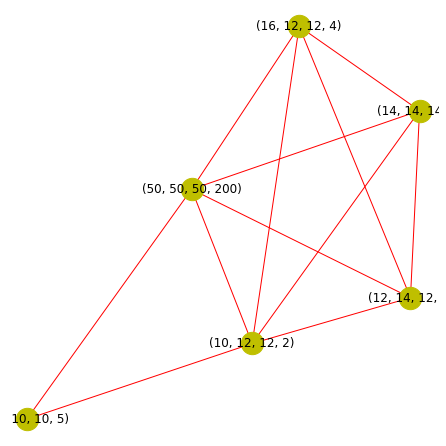

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

circles = getCircles("data/day23test2.txt")

# build a graph with edges defined by bots with overlapping ranges
Gx = nx.Graph()
for c in circles:
    for o in circles:
        if c is not o and overlapping(c,o):
            Gx.add_edge(c,o)

plt.figure(figsize=(6,6))
pos = nx.spring_layout(Gx)
nx.draw(Gx,pos,cmap=plt.get_cmap('jet'),node_size = 500,edge_color='r',node_color="y")
lab = nx.draw_networkx_labels(Gx, pos)

### Clique problem + some (Manhattan) geometry

Searching aroung I discovered the existence of the ["Clique" problem](https://en.wikipedia.org/wiki/Clique_problem), that resembles to what I'm trying to find out, i.e. the largest connected subgraph in my graph of bots connected by their overlap.

#### Some considerations

* First, build a graph of bots as nodes connected by their overlap as edges
* Let `networkx` solve the Clique problem, returning the list of all connected subgraphs (e.g. all sets of bots with a common overlapping range portions)
* From this list I can then extract the set with most bots
* The sought point will sit on the fronteer of the overlap region of this list of bots
* After some doodling (in 2D!) I fuond out that the fronteer of the overlap region closest to the origin is defined by the extreme of the range of the farest bots facing the origin, assuming that the bot range overlap region does not contains the origin itself (and this should be true, otherwise the answer to the puzzle would be the Manhattan distance of the origin itself, i.e. 0)
* All points on the face of the range fronteer of the farest bot facing the origin have the same Manhattan distance because of how the range is defined (these are not spheres, they are octahedrons!), so I can select the largest value of the closest fronteer of all bots in the selected bot set.
* I will also assume that, if a given bot range includes the origi, its fronteer would not be the boubndary of the range overlap. This againa must be true becouse of the considerations of two points above: if not true, the answer would be 0.
* I can compute the closest fronteer as the Manhattan distance betweem the origin and the bot minu the bot range. For the reason mentioned in the point above, I would in some cases obtain a fronteer negative value, but this is ok: those are the fronteers of the bots with ranges including the origin, and the fronteer of their range cannot contain the solution, so they'd be ignored when searching the maximum. This is already seen in the example 

In [11]:
def findClosest(circle,verbose=True):

    # build a graph with edges defined by bots with overlapping ranges
    Gx = nx.Graph()
    for c in circles:
        for o in circles:
            if c is not o and overlapping(c,o):
                Gx.add_edge(c,o)

    # find all groups of overlapping bots by solving the 
    overlap_regions = list(nx.find_cliques(Gx)) # THIS IS WHERE THE MAGIC HAPPENS :-)
    
    # sort overlapping regions by number of bots
    overlap_regions = sorted(overlap_regions,key=len,reverse=True)
    print("Region with most nanobots spans {} bots".format(len(overlap_regions[0])))
    if verbose:
        for b in overlap_regions[0]:
            print(b)

    # collect the distance of the each bot's fronteer closest to the origin
    orig = (0,0,0,0)
    fronteers = [ manhattan(orig,b)-b[3] for b in overlap_regions[0] ]
    
    # return the largest one, e.g. the closest point of the farest bot range
    shortest = max(fronteers)
    print("Shortest manhattan distance =",shortest)
    return shortest

In [13]:
circles = getCircles("data/day23test2.txt")
shortest = findClosest(circles)

Region with most nanobots spans 5 bots
(10, 12, 12, 2)
(50, 50, 50, 200)
(14, 14, 14, 6)
(16, 12, 12, 4)
(12, 14, 12, 2)
Shortest manhattan distance = 36


In [14]:
circles = getCircles("data/input23.txt")
shortest = findClosest(circles,verbose=False)

Region with most nanobots spans 978 bots
Shortest manhattan distance = 97816347
